In [0]:
import pandas as pd
import requests
import cv2
import glob
import numpy as np
import time
from google.colab import drive
import os
from google.colab.patches import cv2_imshow
from keras.models import load_model
from scipy import spatial
from keras.models import Model

Using TensorFlow backend.


Notebook for prediction and testing of our resnet model

In [0]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
os.chdir('./drive/My Drive/greendeck')

Loading our model

In [0]:
my_model = load_model('resnet.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


All images have been converted into arrays and compressed into 1 file for convenience

In [0]:
loaded = np.load('compressed_best.npz')
images = loaded['a']
labels = loaded['b']

In [0]:
len(images)

15674

In [0]:
def image_generator():
  for i in images[:10000]:
    yield(np.expand_dims(i,0))
  

In [0]:
a = image_generator()

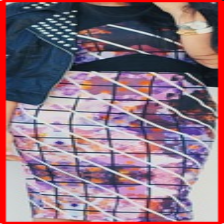

In [0]:
cv2_imshow(next(a))

In [0]:
df = pd.read_csv("dress_patterns.csv")
class_dict = {}
cnt = 0
for i in df['category']:
  if i not in class_dict:
    class_dict[i] = cnt
    cnt += 1

In [0]:
inv_map = {v: k for k, v in class_dict.items()}

First let's check our model 

In [0]:
def prediction(no):
  cv2_imshow(images[no])
  print('actual label:',inv_map[labels[no]])
  percent = my_model.predict(np.expand_dims(images[no],0))[0]
  list1, list2 = zip(*sorted(zip(percent, class_dict.keys())))
  print(list2[-1],list1[-1]*100)
  print(list2[-2],list1[-2]*100)
  print(list2[-3],list1[-3]*100)
  print(list2[-4],list1[-4]*100)

prediction function takes 1 argument i.e id from csv anything between 0-15674. If looking from csv subtract the given id by 2.

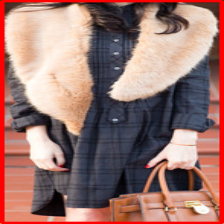

actual label: squares
squares 76.52083039283752
stripes 8.468884229660034
plain 5.609124526381493
polka dot 2.490430884063244


In [0]:
prediction(10)

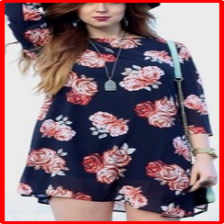

actual label: floral
floral 89.29975032806396
OTHER 3.061710298061371
cartoon 2.1789439022541046
ikat 2.0163020119071007


In [0]:
prediction(8)

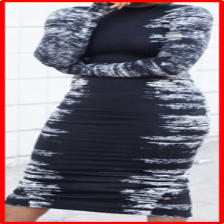

actual label: scales
plain 37.064921855926514
floral 13.149930536746979
OTHER 6.476392596960068
ikat 6.202072650194168


In [0]:
prediction(17)

In this example, as we can see the model predicts plain instead of scales thats because plain region mostly dominates
hence, model has to be fine tuned more

In [0]:
me_model = Model(input=my_model.input,
                  output=my_model.get_layer('flatten').output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  


Next is showing similiar images given a primary image. We are gonna use the same model but remove its last softmax layer and use 2048 embedding vector for determing similarity

In [0]:
def similiar_images(no,range1=0,range2=15674):
  print('main image label:',inv_map[labels[no]])
  main_image = me_model.predict(np.expand_dims(images[no],0))[0]
  predictions = me_model.predict(images[range1:range2])
  print('predictions ready...')
  distances = []
  for i in predictions:
    distances.append(spatial.distance.cosine(main_image,i))
  print('distances ready ...')
  #labels_list = [inv_map[i] for i in labels[range1:range2]]
  list1, list3= zip(*sorted(zip(distances,list(range(range1,range2)))))
  if no in list3:
    list3 = list(list3) 
    list3.remove(no)
    
  print('main image')
  cv2_imshow(images[no])
  print('Similar image 1')
  cv2_imshow(images[list3[0]])
  print('Similar image 2')
  cv2_imshow(images[list3[1]])
  print('similar image 3')
  cv2_imshow(images[list3[2]])

similar_images function takes 3 arguments : id , range1 and range2 . Since for similarity the 2048 vector has to predicted for all images that is not feasible hence we choose a range. Then we use cosine distance between primary image and a secondary image to determine how close are they.
Euclidean distance can also be used.

In [0]:
similiar_images(8,0,2000)

In [0]:
similiar_images(49,0,2000)

In [0]:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

In [0]:
def similiar_images2(no,range1=0,range2=15674):
  print('main image label:',inv_map[labels[no]])
  generator = chunks(images[range1:range2],32)
  main_image = me_model.predict(np.expand_dims(images[no],0))[0]
  predictions = me_model.predict_generator(generator,steps=len(images)/32)
  print('predictions ready...')
  distances = []
  for i in predictions:
    distances.append(spatial.distance.cosine(main_image,i))
  print('distances ready ...')
  #labels_list = [inv_map[i] for i in labels[range1:range2]]
  list1, list3= zip(*sorted(zip(distances,list(range(range1,range2)))))
  if no in list3:
    list3 = list(list3) 
    list3.remove(no)
    
  print('main image')
  cv2_imshow(images[no])
  print('Similar image 1')
  cv2_imshow(images[list3[0]])
  print('Similar image 2')
  cv2_imshow(images[list3[1]])
  print('similar image 3')
  cv2_imshow(images[list3[2]])

main image label: polka dot
predictions ready...
distances ready ...
main image


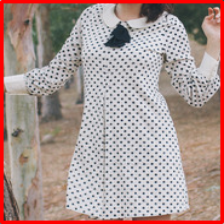

Similar image 1


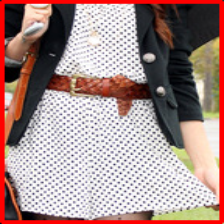

Similar image 2


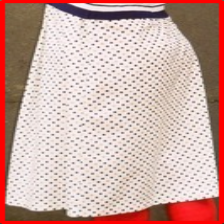

similar image 3


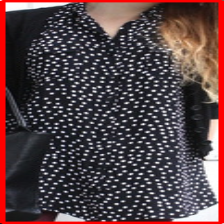

In [0]:
similiar_images2(35)